<a href="https://colab.research.google.com/github/jcandane/PySCF_diffraction/blob/main/PySCF_Diffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pyscf

import numpy as np
import matplotlib.pyplot as plt
from pyscf import scf, gto
from scipy.special import gamma, factorial2, hyp1f1
import inspect

π = np.pi

## https://web.mit.edu/8.02t/www/802TEAL3D/visualizations/coursenotes/modules/guide14.pdf

# 1. Defintions

In [29]:
def kadsum(Matrix, l):
    ## we then need to contract n_ab -> n_αβ
    
    l   = l.astype(np.int32)
    out = np.zeros((len(l)-1, len(l)-1))
    for i in range(len(l)-1):
        for j in range(len(l)-1):
            out[i][j] = np.sum( Matrix[ l[i]:l[i+1], l[j]:l[j+1] ] )

    return out

def molcoefficients(mol, exact=True):
    
    l    = np.array([])
    ζ    = np.array([])
    R_αx = np.zeros( (mol.nao, 3) )
    d_a  = []
    AOi  = np.zeros(1)

    aos = 0 ## to count AO basis-functions
    for i in range(mol.nbas): ## for-loop over shells
        d_aA    = mol.bas_ctr_coeff(i)
        l_shell = int( mol.bas_angular(i) )
        ζ_shell = mol.bas_exp(i)
        R_shell = 0.529177211 * mol.bas_coord(i) ## to get in Å
        for Z in range(d_aA.shape[1]): ## for-loop over Zeta-Basis
            for α in range(2 * l_shell + 1): ## for-loop over AO basis
                R_αx[aos] = R_shell
                d_a  = np.append( d_a , d_aA[:,Z] )
                ζ    = np.append( ζ , ζ_shell )
                aos += 1
                l    = np.append( l , l_shell * np.ones(len(ζ_shell)) )
                AOi  = np.append( AOi , AOi[-1] + len(ζ_shell) )
    
    ζ_ab  =  np.einsum("A, B -> AB", ζ, np.ones(len(ζ))) + np.einsum("B, A -> AB", ζ, np.ones(len(ζ)))
    l_ab  = (np.einsum("A, B -> AB", l, np.ones(len(l))) + np.einsum("B, A -> AB", l, np.ones(len(l))) + 3)/2
    R_xαβ =  np.einsum("Ax, B -> xAB", R_αx, np.ones(R_αx.shape[0])) - np.einsum("Bx, A -> xAB", R_αx, np.ones(R_αx.shape[0]))

    if exact:
        return R_xαβ, ζ_ab, l_ab, AOi
    else:
        A = kadsum( 2 * l_ab / ( 12 * ζ_ab ) , AOi) 
        B = kadsum( 2 * l_ab * (l_ab + 1) / (60 * ζ_ab**2), AOi)
        return R_xαβ, A, B, AOi

def getf_q(A, B, AOi, q, exact=True):
    q2 = np.dot(q,q)
    if exact:
        return kadsum(  hyp1f1(B, 1.5, - q2/(4*A) ) , AOi)
    else:
        return 1 + A * q2 + B * q2 * q2

def diffpattern(mol, D, detector, exact=True):

    R, A, B, AOi = molcoefficients(mol, exact=exact)
    S    = mol.intor("int1e_ovlp")
    q_Dx = detector.q
    I_q  = np.zeros(len(q_Dx))
    for i in range(len(q_Dx)):
        f      = getf_q(A, B, AOi, q_Dx[i], exact=exact)
        qR     = np.einsum("x, xAB -> AB", q_Dx[i], R)
        #I_q[i] = np.einsum("sAB, AB, AB, AB -> ", D, S, f, np.cos(qR))
        I_q[i] = np.einsum("sAB, AB, AB -> ", D, S, np.cos(qR)) ## !!

    return I_q

def diffpatternX(mol, D, detector, dQ=0.01, exact=True):

    R, A, B, AOi = molcoefficients(mol, exact=exact)
    S    = mol.intor("int1e_ovlp")

    Q  = np.arange(0., int( np.linalg.norm(detector.q[0]) + 1 ), dQ) ##np.max( np.linalg.norm( detector2.q , axis=1) )
    f_Q = np.zeros((len(Q), len(S), len(S)))
    for i in range(len(Q)):
        f_Q[i] = getf_q(A, B, AOi, np.array([Q[i],0.,0.]), exact=True)

    ## given q (magnitude) find 2d array.
    q  = np.linalg.norm(detector.q, axis=1)
    q *= 1/dQ
    N, dx = q.astype(int), q-(q).astype(int)
    
    return np.einsum("sAB, BC, qCD, qDE -> q", D, S, f_Q[N] + (f_Q[N+1] - f_Q[N] ) * dx[:,None,None], np.cos(np.einsum("qx, xAB -> qAB", detector.q, R)))

# 2. Double-Slit Example 

In [15]:
size = 5  ## unit
N_H  = 4
N_V  = 1
λ    = 1  ## unit
L    = 10 ## unit
q    = np.array([0., 0., 0.])
k_in = np.array([0., 0., 2*np.pi/λ])

detectorH = np.linspace(0, size*N_H, N_H, endpoint=False) - size*(N_H - 1)/2 + (q + k_in)[0]
detectorV = np.linspace(0, size*N_V, N_V, endpoint=False) - size*(N_V - 1)/2 + (q + k_in)[1]
H, V = np.meshgrid(detectorH, detectorV)
detector_HVx = np.asarray([H, V, L*np.ones(H.shape)]).T
k_Dx         = detector_HVx.reshape((detector_HVx[:,:,0].size,3), order="F")
k_out        = np.einsum("Dx, D -> Dx", k_Dx, np.linalg.norm(k_in)/np.linalg.norm(k_Dx, axis=1) ) ## normalize k_out to match k_in
q            = k_out - k_in

Define a Detector class, which is defined by λ (wavelength), L (distance), pixel-physical size, and N_V (number of pixels vertically), N_H 

In [16]:
class diffraction_detector(object):
    ''' A class of diffraction detector instrament '''
    def __init__(self, λ=1.0, L=1e8, pixelsize=1e5, N_H=100, N_V=1, q_center=np.zeros(3), k_in=np.array([0.,0.,1.])):
        """This class assumes a rectangular detector array with square pixels"""
        self.λ         = λ         ## in-wavelength (in Å)
        self.L         = L         ## detector distance from slit (in Å)
        self.pixelsize = pixelsize ## detector physical size (in Å)
        self.N_H       = N_H ## detector pixel size 
        self.N_V       = N_V ## detector pixel size
        self.k_in      = 2*np.pi/self.λ * k_in
        self.center    = q_center

        detectorH = np.linspace(0, self.pixelsize*self.N_H, self.N_H, endpoint=False) - self.pixelsize*(self.N_H - 1)/2 + (self.center + self.k_in)[0]
        detectorV = np.linspace(0, self.pixelsize*self.N_V, self.N_V, endpoint=False) - self.pixelsize*(self.N_V - 1)/2 + (self.center + self.k_in)[1]
        H, V      = np.meshgrid(detectorH, detectorV)
        detector2 = np.asarray([H, V, self.L*np.ones(H.shape)]).T
        k_Dx      = detector2.reshape((detector2[:,:,0].size,3), order="F")
        k_out     = np.einsum("Dx, D -> Dx", k_Dx, np.linalg.norm(self.k_in)/np.linalg.norm(k_Dx, axis=1) ) ## normalize k_out to match k_in
        self.q    = k_out - self.k_in

    def qq(self):
        return np.reshape(self.q, (self.N_H, self.N_V,3), order="F")

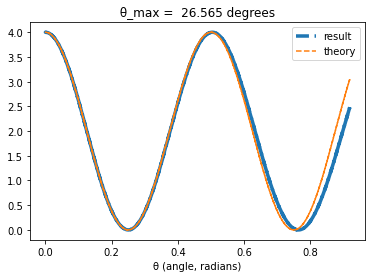

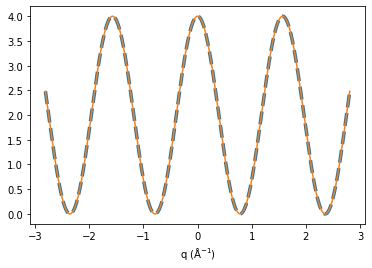

In [17]:
λ     = 1  ## unit
a     = 4
R_ix  = np.array([[-a/2, 0. , 0.],[a/2, 0., 0.]])
R_ijx = np.einsum("ix, j -> ijx", R_ix, np.ones(len(R_ix))) - np.einsum("jx, i -> ijx", R_ix, np.ones(len(R_ix)))

detector1 = diffraction_detector(L=1e9, λ= λ, N_H=10000, N_V=1) ## 4e7

θ_D   = λ * np.linalg.norm(detector1.q, axis=1) / (2*np.pi) *2
s_D   = np.einsum("Dij -> D",  np.cos( np.einsum("Dx, ijx -> Dij", detector1.q, R_ijx) ) ) #- 2
θ_max = (180/π) * np.arctan(detector1.pixelsize*detector1.N_H/2/detector1.L)

plt.plot( θ_D ,  s_D.real, linestyle="dashed", label="result", linewidth=3.5)
plt.plot( θ_D , (2*np.cos( (2*π/λ)*a * θ_D/2 /2 ))**2, linestyle="dashed", label="theory")
plt.xlabel("θ (angle, radians)")
plt.legend()
plt.title(" θ_max =  %4.3f degrees " % θ_max )
plt.show()


q_vector = detector1.q[:,0]
plt.plot( q_vector ,  s_D.real, linestyle="dashed", label="result", linewidth=3.5)
plt.plot( q_vector ,  (2*np.cos( q_vector*a/2 ))**2, label="theory")
plt.xlabel("q (Å$^{-1}$)")
plt.show()

# 2D Implemenation

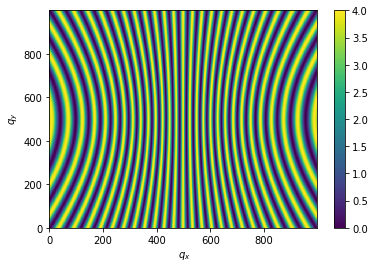

In [18]:
### detector inputs:
λ  = 1   ## Å
L  = 5e8 ## Å
detector2 = diffraction_detector(L=L, λ= λ, N_H=1000, N_V=1000, pixelsize=1e6) ## pixelsize = 1e6 Å = 100 µm

## sample inputs
a     = 20 ## Å
R_ix  = np.array([[-a/2, 0. , 0.],[a/2, 0., 0.]])
R_ijx = np.einsum("ix, j -> ijx", R_ix, np.ones(len(R_ix))) - np.einsum("jx, i -> ijx", R_ix, np.ones(len(R_ix)))

## Intensity Calculation
I_q  = np.einsum("Dij -> D",  np.cos( np.einsum("Dx, ijx -> Dij", detector2.q, R_ijx) ) )

## Plot
s_DE = np.reshape(I_q, (detector2.N_H, detector2.N_V), order="F") ### I back to 2D-detector dimensions
qq   = detector2.qq() ### q back to 2D-detector dimensions
qqq  = np.arange(0,1000,1)
xv, yv = np.meshgrid(qqq, qqq)
plt.pcolormesh(yv, xv, s_DE) ## /(0.25 - qq[:,:,2]) /(0.25 - qq[:,:,2])
plt.xlabel(" $q_x$ ")
plt.ylabel(" $q_y$ ")
plt.colorbar()
plt.show()

# 3. Molecular Example

converged SCF energy = -0.185016615740653  <S^2> = -4.4408921e-16  2S+1 = 1


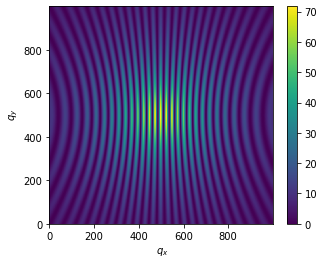

In [19]:
mol_o2 = gto.M(atom='H -10 0 0; H 10, 0, 0', spin=0, basis="sto-3g")
uhf_o2 = scf.UHF(mol_o2)
uhf_o2.kernel()

S_αβ  = mol_o2.intor("int1e_ovlp")
D_sαβ = uhf_o2.make_rdm1()
C_sαp = uhf_o2.mo_coeff

detector1 = diffraction_detector(L=5e8, N_H=1000, N_V=1000, λ=1, pixelsize=1e6) ## L=4e7, N_H=1000, N_V=100, λ=10

#I_q  = diffpattern(mol_o2, D_sαβ, detector1, exact=True)
R, A, B, AOi = molcoefficients(mol_o2, exact=True) ### get molecular information
q_Dx = detector1.q
I_q  = np.zeros(len(q_Dx))
ff_q = np.zeros((len(q_Dx), len(S_αβ), len(S_αβ)))
for i in range(len(q_Dx)):
    ff_q[i] = getf_q(A, B, AOi, q_Dx[i], exact=True)
    qR     = np.einsum("x, xAB -> AB", q_Dx[i], R)
    #I_q[i] = np.einsum("AB -> ", np.cos(qR)) ## !!
    #I_q[i] = np.einsum("sAB, BC, CD -> ", D_sαβ, S_αβ, np.cos(qR))
    I_q[i] = np.einsum("sAB, BC, CD, DE -> ", D_sαβ, S_αβ, ff_q[i], np.cos(qR))
    #I_q[i] = np.einsum("sAB, AB, AB -> ", D_sαβ, S_αβ, np.cos(qR)) ## !!

s_DE = np.reshape(I_q, (detector1.N_H, detector1.N_V), order="F") ### back to 2D-detector dimensions
qq   = detector1.qq() ### back to 2D-detector dimensions

qqq  = np.arange(0,1000,1)
xv, yv = np.meshgrid(qqq, qqq)

plt.figure(figsize=(5,4))
plt.pcolormesh(yv, xv, s_DE)  ## qq[:,:,0], qq[:,:,1]
plt.xlabel(" $q_x$ ")
plt.ylabel(" $q_y$ ")
plt.colorbar()
plt.show()

In [20]:
dQ = 0.01
Q  = np.arange(0., int( np.linalg.norm(detector2.q[0]) + 1 ), dQ) ##np.max( np.linalg.norm( detector2.q , axis=1) )
f_q = np.zeros((len(Q), len(S_αβ), len(S_αβ)))
for i in range(len(Q)):
    f_q[i] = getf_q(A, B, AOi, np.array([Q[i],0.,0.]), exact=True)

f_q.shape

## given q (magnitude) find 2d array.
q  = np.linalg.norm(detector2.q, axis=1)
q *= 1/dQ
N, dx = q.astype(int), q-(q).astype(int) ## not memory intensive...

F_q = f_q[N] + (f_q[N+1] - f_q[N] ) * dx[:,None,None]

F_q.shape

(1000000, 2, 2)

# NEW IDEA

converged SCF energy = -0.185016615740653  <S^2> = -4.4408921e-16  2S+1 = 1


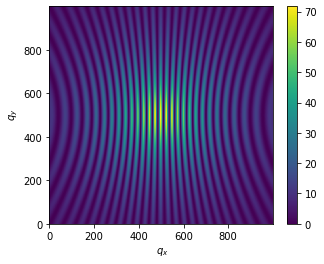

In [21]:
mol_o2 = gto.M(atom='H -10 0 0; H 10, 0, 0', spin=0, basis="sto-3g")
uhf_o2 = scf.UHF(mol_o2)
uhf_o2.kernel()

S_αβ  = mol_o2.intor("int1e_ovlp")
D_sαβ = uhf_o2.make_rdm1()
C_sαp = uhf_o2.mo_coeff

detector1 = diffraction_detector(L=5e8, N_H=1000, N_V=1000, λ=1, pixelsize=1e6) ## L=4e7, N_H=1000, N_V=100, λ=10

#I_q  = diffpattern(mol_o2, D_sαβ, detector1, exact=True)
R, A, B, AOi = molcoefficients(mol_o2, exact=True) ### get molecular information
q_Dx = detector1.q
#I_q = np.einsum("sAB, BC, qCD, qDE -> q", D_sαβ, S_αβ, ff_q, np.cos(np.einsum("qx, xAB -> qAB", q_Dx, R)))
#I_q = np.einsum("sAB, BC, qCD, qDE -> q", D_sαβ, S_αβ, F_q, np.cos(np.einsum("qx, xAB -> qAB", q_Dx, R)))
I_q = np.einsum("sAB, BC, qCD, qDE -> q", D_sαβ, S_αβ, f_q[N] + (f_q[N+1] - f_q[N] ) * dx[:,None,None], np.cos(np.einsum("qx, xAB -> qAB", q_Dx, R)))

s_DE = np.reshape(I_q, (detector1.N_H, detector1.N_V), order="F") ### back to 2D-detector dimensions
qq   = detector1.qq() ### back to 2D-detector dimensions

qqq  = np.arange(0,1000,1)
xv, yv = np.meshgrid(qqq, qqq)

plt.figure(figsize=(5,4))
plt.pcolormesh(yv, xv, s_DE)  ## qq[:,:,0], qq[:,:,1]
plt.xlabel(" $q_x$ ")
plt.ylabel(" $q_y$ ")
plt.colorbar()
plt.show()

NEW NEW Implemeted

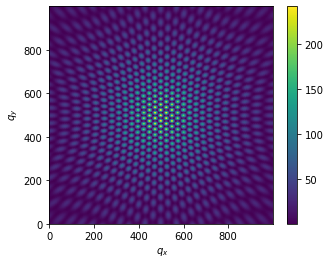

In [30]:
I_q = diffpatternX(mol_o2, D_sαβ, detector1, exact=True)

s_DE = np.reshape(I_q, (detector1.N_H, detector1.N_V), order="F") ### back to 2D-detector dimensions

qqq  = np.arange(0,1000,1)
xv, yv = np.meshgrid(qqq, qqq)

plt.figure(figsize=(5,4))
plt.pcolormesh(yv, xv, s_DE)  ## qq[:,:,0], qq[:,:,1]
plt.xlabel(" $q_x$ ")
plt.ylabel(" $q_y$ ")
plt.colorbar()
plt.show()

# Make program to output the method into a python file, and uploads it to GitHub

converged SCF energy = -0.648805129067145  <S^2> = 0.75  2S+1 = 2


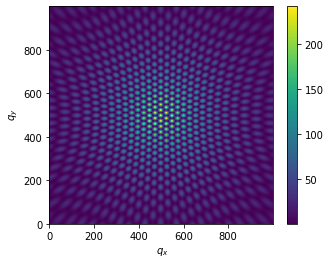

In [22]:
mol_o2 = gto.M(atom='H -10 0 0; H 10, 0, 0; H 0 20 0', spin=1, basis="sto-3g")
uhf_o2 = scf.UHF(mol_o2)
uhf_o2.kernel()

S_αβ  = mol_o2.intor("int1e_ovlp")
D_sαβ = uhf_o2.make_rdm1()
C_sαp = uhf_o2.mo_coeff

detector1 = diffraction_detector(L=5e8, N_H=1000, N_V=1000, λ=1, pixelsize=1e6) ## L=4e7, N_H=1000, N_V=100, λ=10

def get_diffpattern(mol, detector, D_sαβ):
    """
    Given: mol (pyscf object), detector (custom object), D_sαβ (AO density-matrix)
    Get  : I_q (Diffraction Intensity)
    """
    DS = (D_sαβ[0] + D_sαβ[1]) @ (mol.intor("int1e_ovlp"))

    R, A, B, AOi = molcoefficients(mol, exact=True) ### get molecular information
    q_Dx = detector.q
    I_q  = np.zeros(len(q_Dx))
    for i in range(len(q_Dx)):
        I_q[i] = np.sum( DS @ getf_q(A, B, AOi, q_Dx[i], exact=True) @ np.cos(q_Dx[i,0]*R[0] + q_Dx[i,1]*R[1] + q_Dx[i,2]*R[2]) )

    return I_q

I_q  = get_diffpattern(mol_o2, detector1, D_sαβ)
s_DE = np.reshape(I_q, (detector1.N_H, detector1.N_V), order="F") ### back to 2D-detector dimensions

qqq  = np.arange(0,1000,1)
xv, yv = np.meshgrid(qqq, qqq)

plt.figure(figsize=(5,4))
plt.pcolormesh(yv, xv, s_DE)  ## qq[:,:,0], qq[:,:,1]
plt.xlabel(" $q_x$ ")
plt.ylabel(" $q_y$ ")
plt.colorbar()
plt.show()

## Let's save/export these defintions for later, in an exterior python file:

In [23]:
!git clone https://github.com/jcandane/pyprototyp

fatal: destination path 'pyprototyp' already exists and is not an empty directory.


In [31]:
from pyprototyp.pyprototyp import pyprototyp

pyprototyp("PySCF_Diffraction", packages=["from scipy.special import hyp1f1"], useful=[], defs=[kadsum, molcoefficients, getf_q, get_diffpattern, diffpatternX], classes=[diffraction_detector])